In [1]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
import matplotlib.pyplot as plt
from MDAnalysis.analysis.distances import dist
from tqdm import tqdm
import pandas as pd
import pickle
import red

/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
def obtain_RMSD(run_numbers, species='complex'):
    """Obtain RMSD for a list of run numbers"""

    if species == 'complex':
        filename = 'RMSD.csv'
    elif species == 'BD2':
        filename = 'RMSD_BD2.csv'
    else:
        filename = 'RMSD_DCAF16.csv'

    if isinstance(run_numbers, int):
        run_numbers = [run_numbers]

    RMSDs = []

    for run_number in run_numbers:
        df = pd.read_csv(f"results/run{run_number}/{filename}")
        time = df['Time (ns)'].to_numpy()
        RMSDs.append(df['RMSD (Angstrom)'].to_numpy())

    RMSDs = np.array(RMSDs)

    return time, np.average(RMSDs, axis=0)

In [3]:
def obtain_RMSF(run_number, species='complex'):

    if species == 'complex':
        filename = 'RMSF.csv'
    elif species == 'BD2':
        filename = 'RMSF_BD2.csv'
    else:
        filename = 'RMSF_DCAF16.csv'

    df = pd.read_csv(f"results/run{run_number}/{filename}")

    residx = df['Residue index'].to_numpy()
    RMSF = df['RMSF (Angstrom)'].to_numpy()

    return residx, RMSF

In [4]:
def obtain_av_RMSF(run_numbers, species='complex'):

    RMSFs = []

    for run_number in run_numbers:

        res, rmsf = obtain_RMSF(run_number, species)
        RMSFs.append(rmsf)

    RMSFs = np.array(RMSFs)

    return res, np.average(RMSFs, axis=0), np.std(RMSFs, axis=0)
        

In [5]:
def obtain_CA_idx(u, res_idx):
    """Function to obtain the index of the alpha carbon for a given residue index"""
    
    selection_str = f"protein and resid {res_idx} and name CA"
    
    selected_CA = u.select_atoms(selection_str)

    if len(selected_CA.indices) == 0:
        print('CA not found for the specified residue...')
    
    elif len(selected_CA.indices) > 1:
        print('Multiple CAs found, uh oh...')

    else:  
        return selected_CA.indices[0]

In [6]:
def obtain_distance(pos1, pos2):

    return np.linalg.norm(pos1 - pos2)

In [7]:
def obtain_angle(pos1, pos2, pos3):

    return mda.lib.distances.calc_angles(pos1, pos2, pos3)

In [8]:
def obtain_dihedral(pos1, pos2, pos3, pos4):

    return mda.lib.distances.calc_dihedrals(pos1, pos2, pos3, pos4)

## Plotting RMSD

Text(0, 0.5, 'RMSD (AA)')

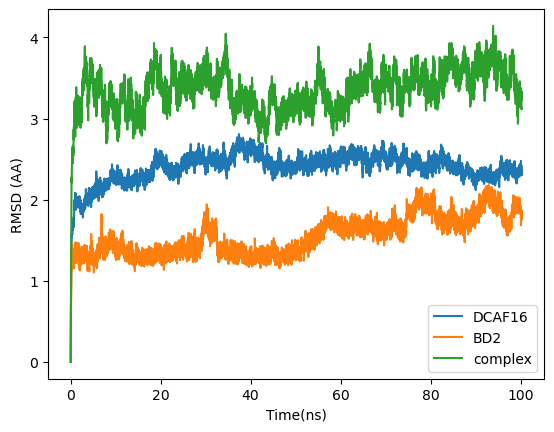

In [9]:
run_numbers = [1,2,3]

systems = ['DCAF16', 'BD2', 'complex']

for species in systems:

    time, RMSD = obtain_RMSD(run_numbers, species)
    plt.plot(time, RMSD, label=species)

plt.legend()
plt.xlabel('Time(ns)')
plt.ylabel('RMSD (AA)')

## Plotting RMSF

Text(0, 0.5, 'Average RMSF (Å)')

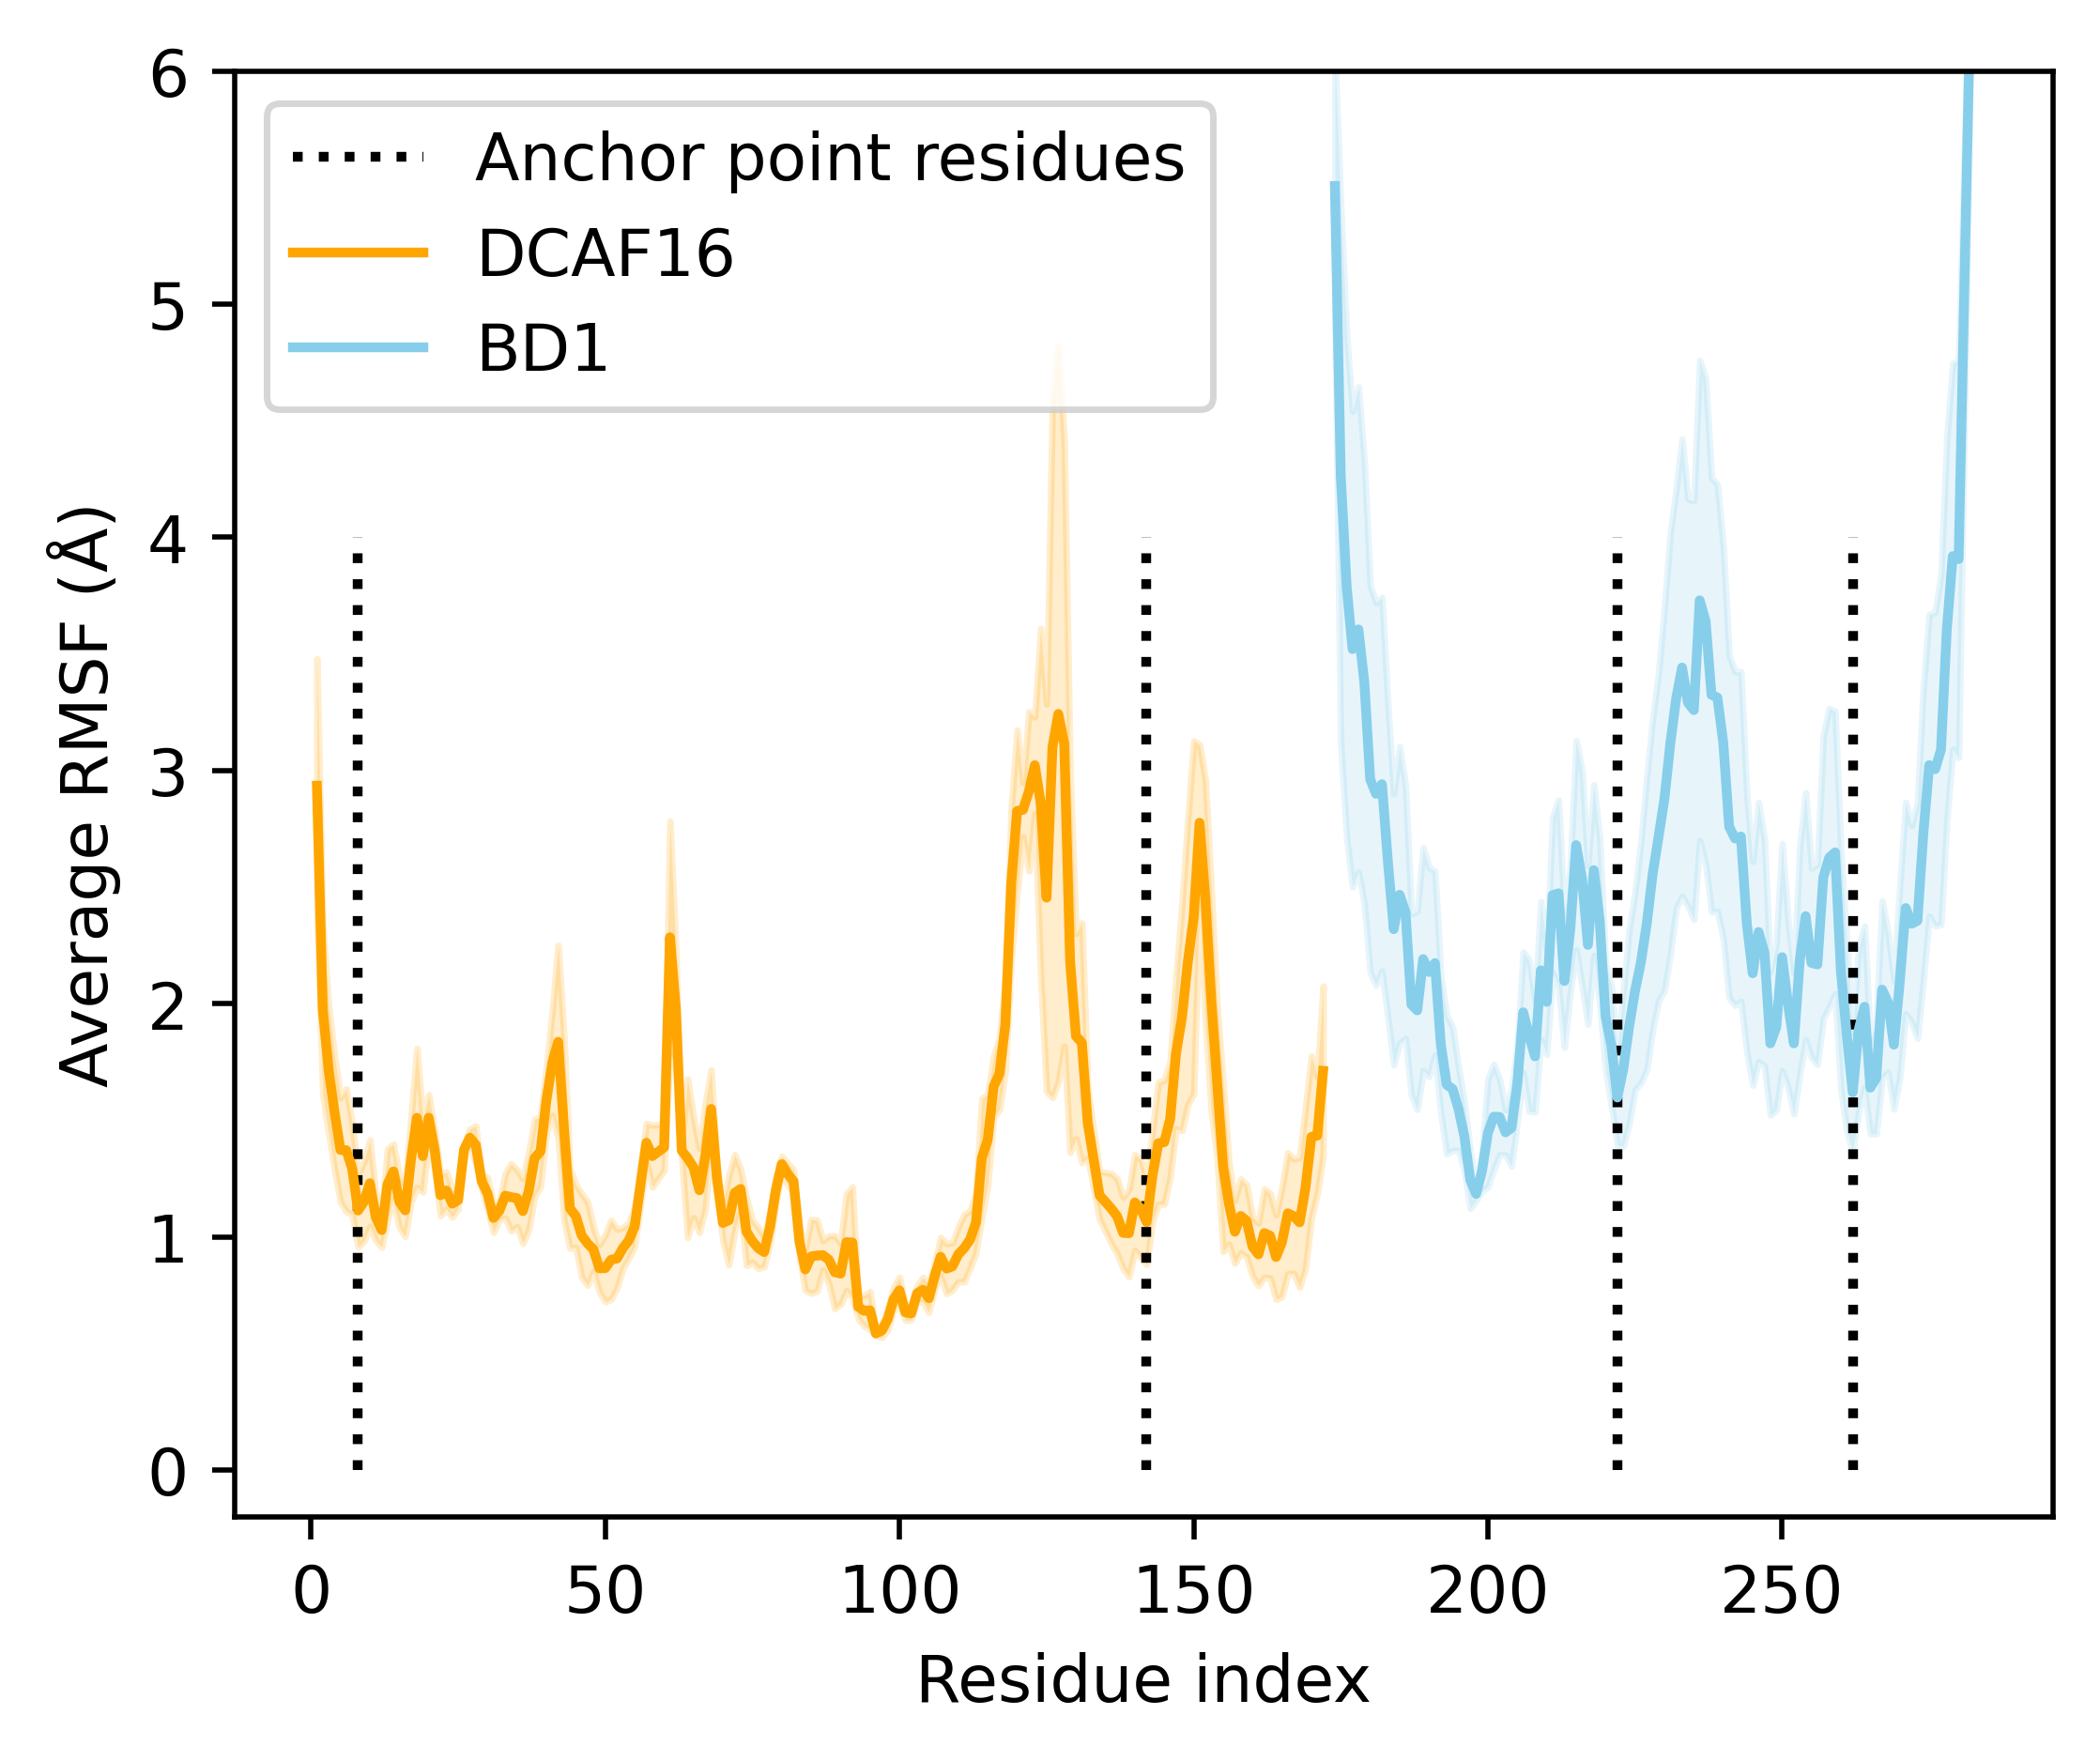

In [10]:
# Boresch_residues = [13, 8, 142, 370, 332, 244]

runs = [1,2,3]

res_DCAF16, av_RMSF_DCAF16, std_RMSF_DCAF16 = obtain_av_RMSF(runs, species='DCAF16')
res_BD2, av_RMSF_BD2, std_RMSF_BD2 = obtain_av_RMSF(runs, species='BD2')

plt.figure(figsize=(5,4), dpi=500)
plt.vlines([8, 142, 262, 222], ymin=4*[0], ymax=4*[4], colors='k', linestyles='dotted', label='Anchor point residues')
plt.plot(res_DCAF16, av_RMSF_DCAF16, c='orange', label='DCAF16')
plt.fill_between(res_DCAF16, av_RMSF_DCAF16-std_RMSF_DCAF16, av_RMSF_DCAF16+std_RMSF_DCAF16, color='orange', alpha=0.2)
plt.plot(res_BD2, av_RMSF_BD2, c='skyblue', label='BD1')
plt.fill_between(res_BD2, av_RMSF_BD2-std_RMSF_BD2, av_RMSF_BD2+std_RMSF_BD2, color='skyblue', alpha=0.2)
plt.legend()
plt.ylim(-0.2, 6.0)
plt.xlabel('Residue index')
plt.ylabel('Average RMSF (Å)')

In [11]:
"""Print Boresch DOFs"""

u = mda.Universe('structures/complex_DDB1.prmtop', 'results/run1/traj.dcd')

u.trajectory[2000] # 20 ns equilibration

rec_group =  [4, 18, 37, 56, 96, 107, 136, 160, 177, 193, 215, 226, 245, 264, 286, 307, 318, 332, 346, 920, 941, 2068, 2084, 2095, 2102, 2112, 2123, 2133, 2140, 2164, 2183, 2197, 2414, 2428, 2442, 2463]
lig_group =  [3045, 3055, 3065, 3096, 3128, 3211, 3227, 3239, 3255, 3270, 3280, 3299, 3306, 3325, 3342, 3354, 4040, 4061, 4083, 4103, 4115, 4132, 4147, 4163, 4179, 4189]

res_b = 8
res_c = 142
res_B = 262
res_C = 222

idx_b = obtain_CA_idx(u, res_b)
idx_c = obtain_CA_idx(u, res_c)
idx_B = obtain_CA_idx(u, res_B)
idx_C = obtain_CA_idx(u, res_C)

pos_a = u.atoms[rec_group].center_of_mass()
pos_b = u.atoms[[idx_b]].center_of_mass()
pos_c = u.atoms[[idx_c]].center_of_mass()
pos_A = u.atoms[lig_group].center_of_mass()
pos_B = u.atoms[[idx_B]].center_of_mass()
pos_C = u.atoms[[idx_C]].center_of_mass()

print(f"ThetaA = {obtain_angle(pos_b, pos_a, pos_A)}")
print(f"ThetaB = {obtain_angle(pos_a, pos_A, pos_B)}")
print(f"PhiA = {obtain_dihedral(pos_c, pos_b, pos_a, pos_A)}")
print(f"PhiB = {obtain_dihedral(pos_b, pos_a, pos_A, pos_B)}")
print(f"PhiC = {obtain_dihedral(pos_a, pos_A, pos_B, pos_C)}\n")

print(f"Theta1 = {obtain_angle(pos_c, pos_b, pos_a)}")
print(f"Theta2 = {obtain_angle(pos_C, pos_B, pos_A)}")

ThetaA = 1.6009764699936093
ThetaB = 1.80619807152524
PhiA = -2.313193505628098
PhiB = -0.7527249857651561
PhiC = 2.3718011657038827

Theta1 = 1.1546249463181277
Theta2 = 1.030701105154369


/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/topology/TOPParser.py:342: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)
/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


### Interface CoM analysis

In [12]:
def getDistance(idx1, idx2, u):
    """
    Get the distance between two atoms in a universe.

    Parameters
    ----------
    idx1 : int
        Index of the first atom
    idx2 : int
        Index of the second atom
    u : MDAnalysis.Universe
        The MDA universe containing the atoms and
        trajectory.

    Returns
    -------
    distance : float
        The distance between the two atoms in Angstroms.
    """
    distance = dist(
        mda.AtomGroup([u.atoms[idx1]]),
        mda.AtomGroup([u.atoms[idx2]]),
        box=u.dimensions,
    )[2][0]
    return distance

def closest_residue_to_point(atoms, point):
    """Find the closest residue in a selection of atoms to a given point"""
    residues = atoms.residues
    distances = np.array([np.linalg.norm(res.atoms.center_of_mass() - point) for res in residues])

    # Find the index of the smallest distance
    closest_residue_index = np.argmin(distances)

    # Return the closest residue
    return residues[closest_residue_index], distances[closest_residue_index]

In [13]:
u = mda.Universe('structures/complex_DDB1.prmtop', 'results/run1/traj.dcd')

# Trajectory has 10020 frames, so jump to frame 2000 for equilibrated structure
u.trajectory[2000] # Frame after 20 ns

receptor_selection_str="resid 1-172 and name CA" # DCAF16
ligand_selection_str = "resid 174-282 and name CA" # BD1

ligand = u.select_atoms(ligand_selection_str)
receptor = u.select_atoms(receptor_selection_str)

ligand_interface = []
receptor_interface = []

# Save all ligand CA indices that are within 12 AA of a receptor CA
for lig_CA in ligand.atoms:
    
    for rec_CA in receptor.atoms:
        distance = getDistance(lig_CA.index, rec_CA.index, u)
        if distance <=12.000: 
            ligand_interface.append(int(lig_CA.index))
            receptor_interface.append(int(rec_CA.index))

# Returns interface residues
ligand_interface=set(ligand_interface)
receptor_interface=set(receptor_interface)   

receptor_interface_res = [
    int(u.select_atoms(f"index {index}").residues.resids[0]) for index in receptor_interface 
]

ligand_interface_res = [
    int(u.select_atoms(f"index {index}").residues.resids[0]) for index in ligand_interface 
]

print(f"\nReceptor interface residues = {sorted(receptor_interface_res)}")
print(f"Ligand interface residues = {sorted(ligand_interface_res)}\n")

rec_interface_selection = "index " + " ".join(map(str, list(receptor_interface)))
lig_interface_selection = "index " + " ".join(map(str, list(ligand_interface)))

# Calculate centers of mass
receptor_com = u.select_atoms(rec_interface_selection).center_of_mass()
ligand_com = u.select_atoms(lig_interface_selection).center_of_mass()

# Find the closest residues
closest_receptor_residue, dist_rec = closest_residue_to_point(u.select_atoms(rec_interface_selection), receptor_com)
closest_ligand_residue, dist_lig = closest_residue_to_point(u.select_atoms(lig_interface_selection), ligand_com)

print(f"CoM separation = {obtain_distance(receptor_com, ligand_com)}")

print(f"Closest residue to receptor COM: {closest_receptor_residue.resname} {closest_receptor_residue.resid}, distance is {dist_rec}")
print(f"Closest residue to ligand COM: {closest_ligand_residue.resname} {closest_ligand_residue.resid}, distance is {dist_lig}")

rec_group = sorted(list(receptor_interface))
print('\nrec_group = ', rec_group)

lig_group = sorted(list(ligand_interface))
print('lig_group = ', lig_group)


Receptor interface residues = [1, 2, 3, 4, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 56, 58, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 153, 154, 155, 156]
Ligand interface residues = [193, 194, 195, 197, 198, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 255, 256, 257, 259, 260, 261, 262, 263, 264, 265]

CoM separation = 10.953838532943612
Closest residue to receptor COM: CYS 134, distance is 3.706425894793098
Closest residue to ligand COM: VAL 262, distance is 5.396573523058167

rec_group =  [4, 18, 37, 56, 96, 107, 136, 160, 177, 193, 215, 226, 245, 264, 286, 307, 318, 332, 346, 920, 941, 2068, 2084, 2095, 2102, 2112, 2123, 2133, 2140, 2164, 2183, 2197, 2414, 2428, 2442, 2463]
lig_group =  [3045, 3055, 3065, 3096, 3128, 3211, 3227, 3239, 3255, 3270, 3280, 3299, 3306, 3325, 3342, 3354, 4040, 4061, 4083, 4103, 4115, 4132, 4147, 4163, 4179, 4189]


### Boresch dof

In [15]:
def obtain_Boresch_dof(run_number, dof):

    boreschfile = f'results/run{run_number}/{dof}.pkl'

    with open(boreschfile, 'rb') as f:
        loaded_data = pickle.load(f)

    frames = loaded_data['Frames']
    time = loaded_data['Time (ns)']
    vals = loaded_data['DOF values']

    return time, vals

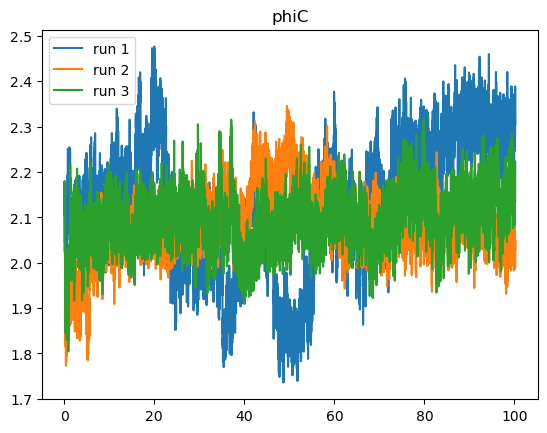

In [16]:
"""Plotting the time evolution of the DOF"""

dof = 'phiC'
positive = True

plt.title(dof)
for run_number in [1,2,3]:
    time, vals = obtain_Boresch_dof(run_number, dof)

    # for n in range(len(vals)):
    #     if positive == True:
    #         if vals[n] < 0:
    #             vals[n] = vals[n] + 2*np.pi
    #     else:
    #         if vals[n] > 0:
    #             vals[n] = vals[n] - 2*np.pi

    plt.plot(time, vals, label=f"run {run_number}")

plt.legend()


2.0693053081173005


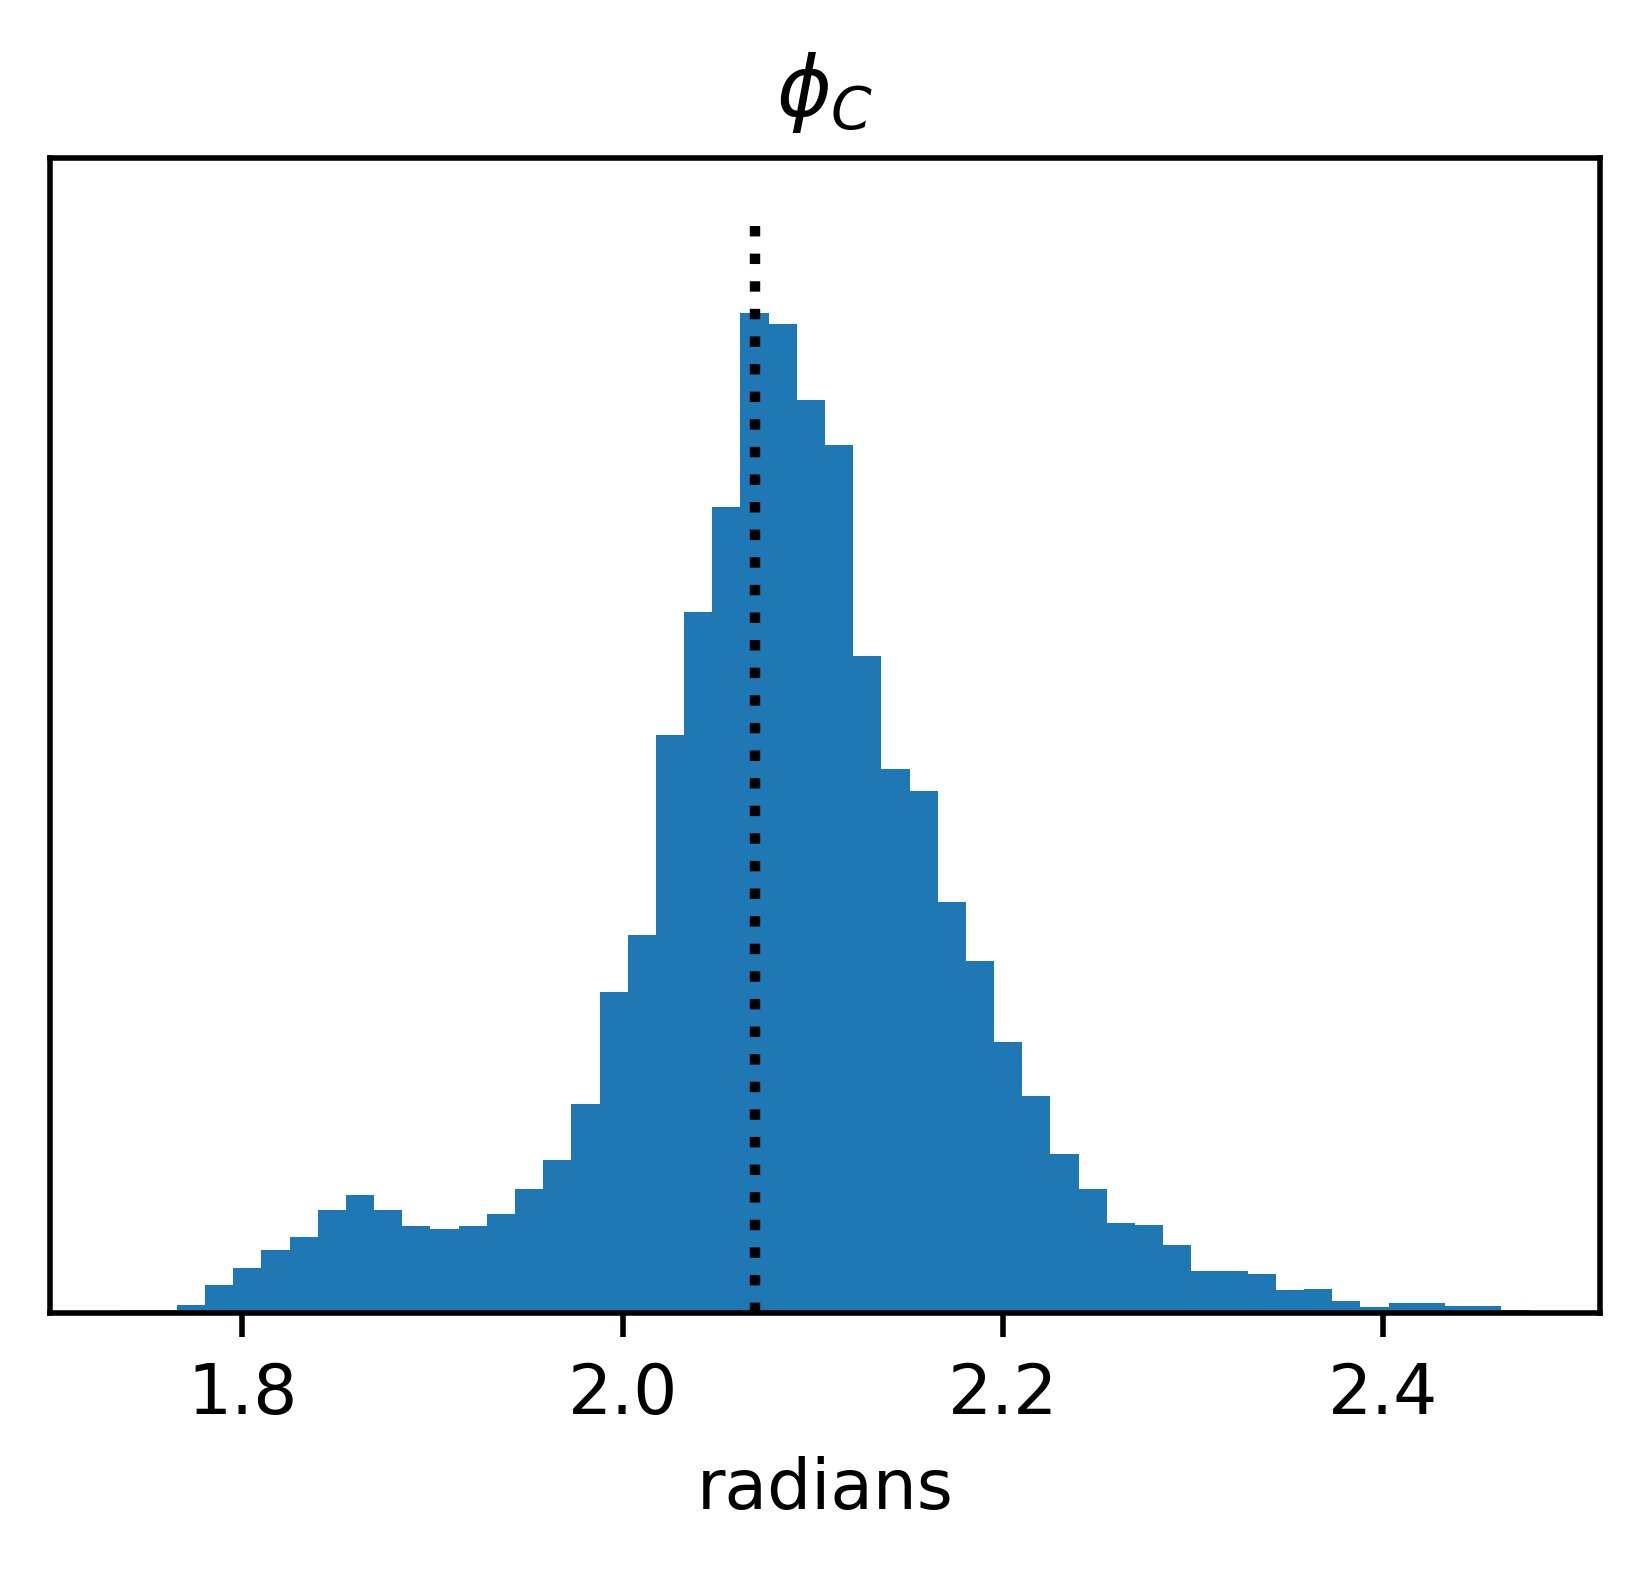

In [22]:
"""Plotting the histogram"""

dof = 'phiC'
equil_time = 10.0  # ns
cutoff_time = 60.0  # ns

positive = True

titles = {'thetaA':'$\Theta _A$', 'thetaB':'$\Theta _B$', 'phiA':'$\phi _A$', 'phiB':'$\phi _B$', 'phiC':'$\phi _C$'}

vals_all = []
plt.figure(figsize=(4,3), dpi=500)
plt.title(titles[dof])

for run_number in [1,2,3]:
    time, vals = obtain_Boresch_dof(run_number, dof)

    # for n in range(len(vals)):
    #     if positive == True:
    #         if vals[n] < 0:
    #             vals[n] = vals[n] + 2*np.pi
    #     else:
    #         if vals[n] > 0:
    #             vals[n] = vals[n] - 2*np.pi

    # get indices robustly from the actual time array
    start_idx = np.searchsorted(time, equil_time, side='left')
    end_idx = np.searchsorted(time, cutoff_time, side='right')  # exclusive end

    # slice
    time_slice = time[start_idx:end_idx]
    vals_slice = vals[start_idx:end_idx]

    # collect values across runs
    vals_all.append(vals_slice)

# combine all runs
if len(vals_all) == 0:
    raise RuntimeError("No data in the requested time window.")
vals_all = np.concatenate(vals_all)

# histogram
counts, bins = np.histogram(vals_all, bins=50)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
peak_center = bin_centers[counts.argmax()]
print(peak_center)

plt.hist(vals_all, bins=50)
plt.vlines(peak_center, ymin=0, ymax=counts.max() * 1.1, colors='k', linestyles='dotted', label='Equilibrium value')
plt.yticks([])
plt.xlabel('radians')
plt.show()

### Saving equilibrated structure

Save run 1 structure after 20 ns equilibration

In [13]:
u = mda.Universe('structures/complex_DDB1.prmtop', f'results/run1/traj.dcd')

save_idx = 20/100.2 * len(u.trajectory)
save_idx = int(np.round(save_idx, 6))

u.trajectory[save_idx]
u.atoms.write('equilibrated_structures/BD2_DCAF16_eq.pdb')

/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/btan/miniconda3/envs/openbiosim/lib/p

Remove hydrogen, water and neutralising ions:

In [ ]:
from pymol import cmd

cmd.reinitialize()

cmd.load(f'equilibrated_structures/BD2_DCAF16_eq.pdb', "complex")

cmd.remove("resn HOH")
cmd.remove("resn WAT")
cmd.remove("hydro")
cmd.remove("resn NA")

cmd.save(f"equilibrated_structures/complex_eq_noH.pdb")


## Analysis of interface CoM

In [10]:
def obtain_CA_idx(u, res_idx):
    """Function to obtain the index of the alpha carbon for a given residue index"""
    
    selection_str = f"protein and resid {res_idx} and name CA"
    
    selected_CA = u.select_atoms(selection_str)

    if len(selected_CA.indices) == 0:
        print('CA not found for the specified residue...')
    
    elif len(selected_CA.indices) > 1:
        print('Multiple CAs found, uh oh...')

    else:  
        return selected_CA.indices[0]

def obtain_distance(pos1, pos2):
    """Obtain the distance between two coordinates"""
    return np.linalg.norm(pos1 - pos2)

In [11]:
u = mda.Universe('structures/complex.prmtop', f'structures/complex.inpcrd')

rec_group = [4, 18, 37, 56, 81, 96, 107, 126, 136, 160, 177, 193, 215, 226, 245, 264, 286, 307, 318, 332, 346, 400, 406, 425, 447, 453, 521, 610, 629, 649, 655, 666, 688, 694, 710, 727, 789, 941, 1872, 1899, 1905, 1920, 1941, 1960, 1999, 2026, 2057, 2068, 2084, 2095, 2102, 2112, 2123, 2133, 2140, 2164, 2183, 2197, 2219, 2463]
lig_group = [3032, 3054, 3071, 3088, 3333, 3360, 3366, 3378, 3442, 4051, 4072, 4091, 4112, 4126, 4156, 4162, 4169, 4181, 4193, 4212, 4228, 4247, 4264, 4274, 4289, 4824, 4834, 4856, 4878, 4895, 4905, 4915, 4936, 4946, 4978, 5025, 5055, 5061, 5077, 5089, 5105, 5120, 5130, 5149, 5156, 5175, 5192, 5204, 5890, 5911, 5933, 5953, 5965, 5982, 5997, 6013, 6039]

rec_atoms = u.atoms[rec_group]
lig_atoms = u.atoms[lig_group]

# Test that all atoms are CAs
for atom in rec_atoms+lig_atoms:
    if atom.name != 'CA':
        raise ValueError('Select only CA atoms as anchorpoints')

/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/topology/TOPParser.py:342: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)


In [14]:
lig_atoms.resids

array([190, 191, 192, 193, 208, 209, 210, 211, 214, 251, 252, 253, 254,
       255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 298,
       299, 300, 301, 302, 303, 304, 305, 306, 307, 310, 311, 312, 313,
       314, 315, 316, 317, 318, 319, 320, 321, 322, 364, 365, 366, 368,
       369, 370, 371, 372, 374])

In [23]:
CoM_sep_data = {}

for n_run in [0,2,4]:
    sep = []
    u = mda.Universe('structures/complex.prmtop', f'results/run{n_run}/traj.dcd')
    
    total_frames = 10020
    frames_per_ns = total_frames / 100.2
    frames_40ns = int(frames_per_ns * 40)

    for ts in tqdm(u.trajectory[:frames_40ns], total=frames_40ns, desc='Frames analysed'):
    
        rec_atoms = u.atoms[rec_group]
        lig_atoms = u.atoms[lig_group] 

        rec_COM = rec_atoms.center_of_mass()
        lig_COM = lig_atoms.center_of_mass()

        sep.append(obtain_distance(rec_COM, lig_COM))

    CoM_sep_data[n_run] = sep

/home/benedicttan/miniconda3/envs/openbiosim/lib/python3.10/site-packages/MDAnalysis/topology/TOPParser.py:342: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)
/home/benedicttan/miniconda3/envs/openbiosim/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
Frames analysed: 100%|██████████| 4000/4000 [00:22<00:00, 176.52it/s]


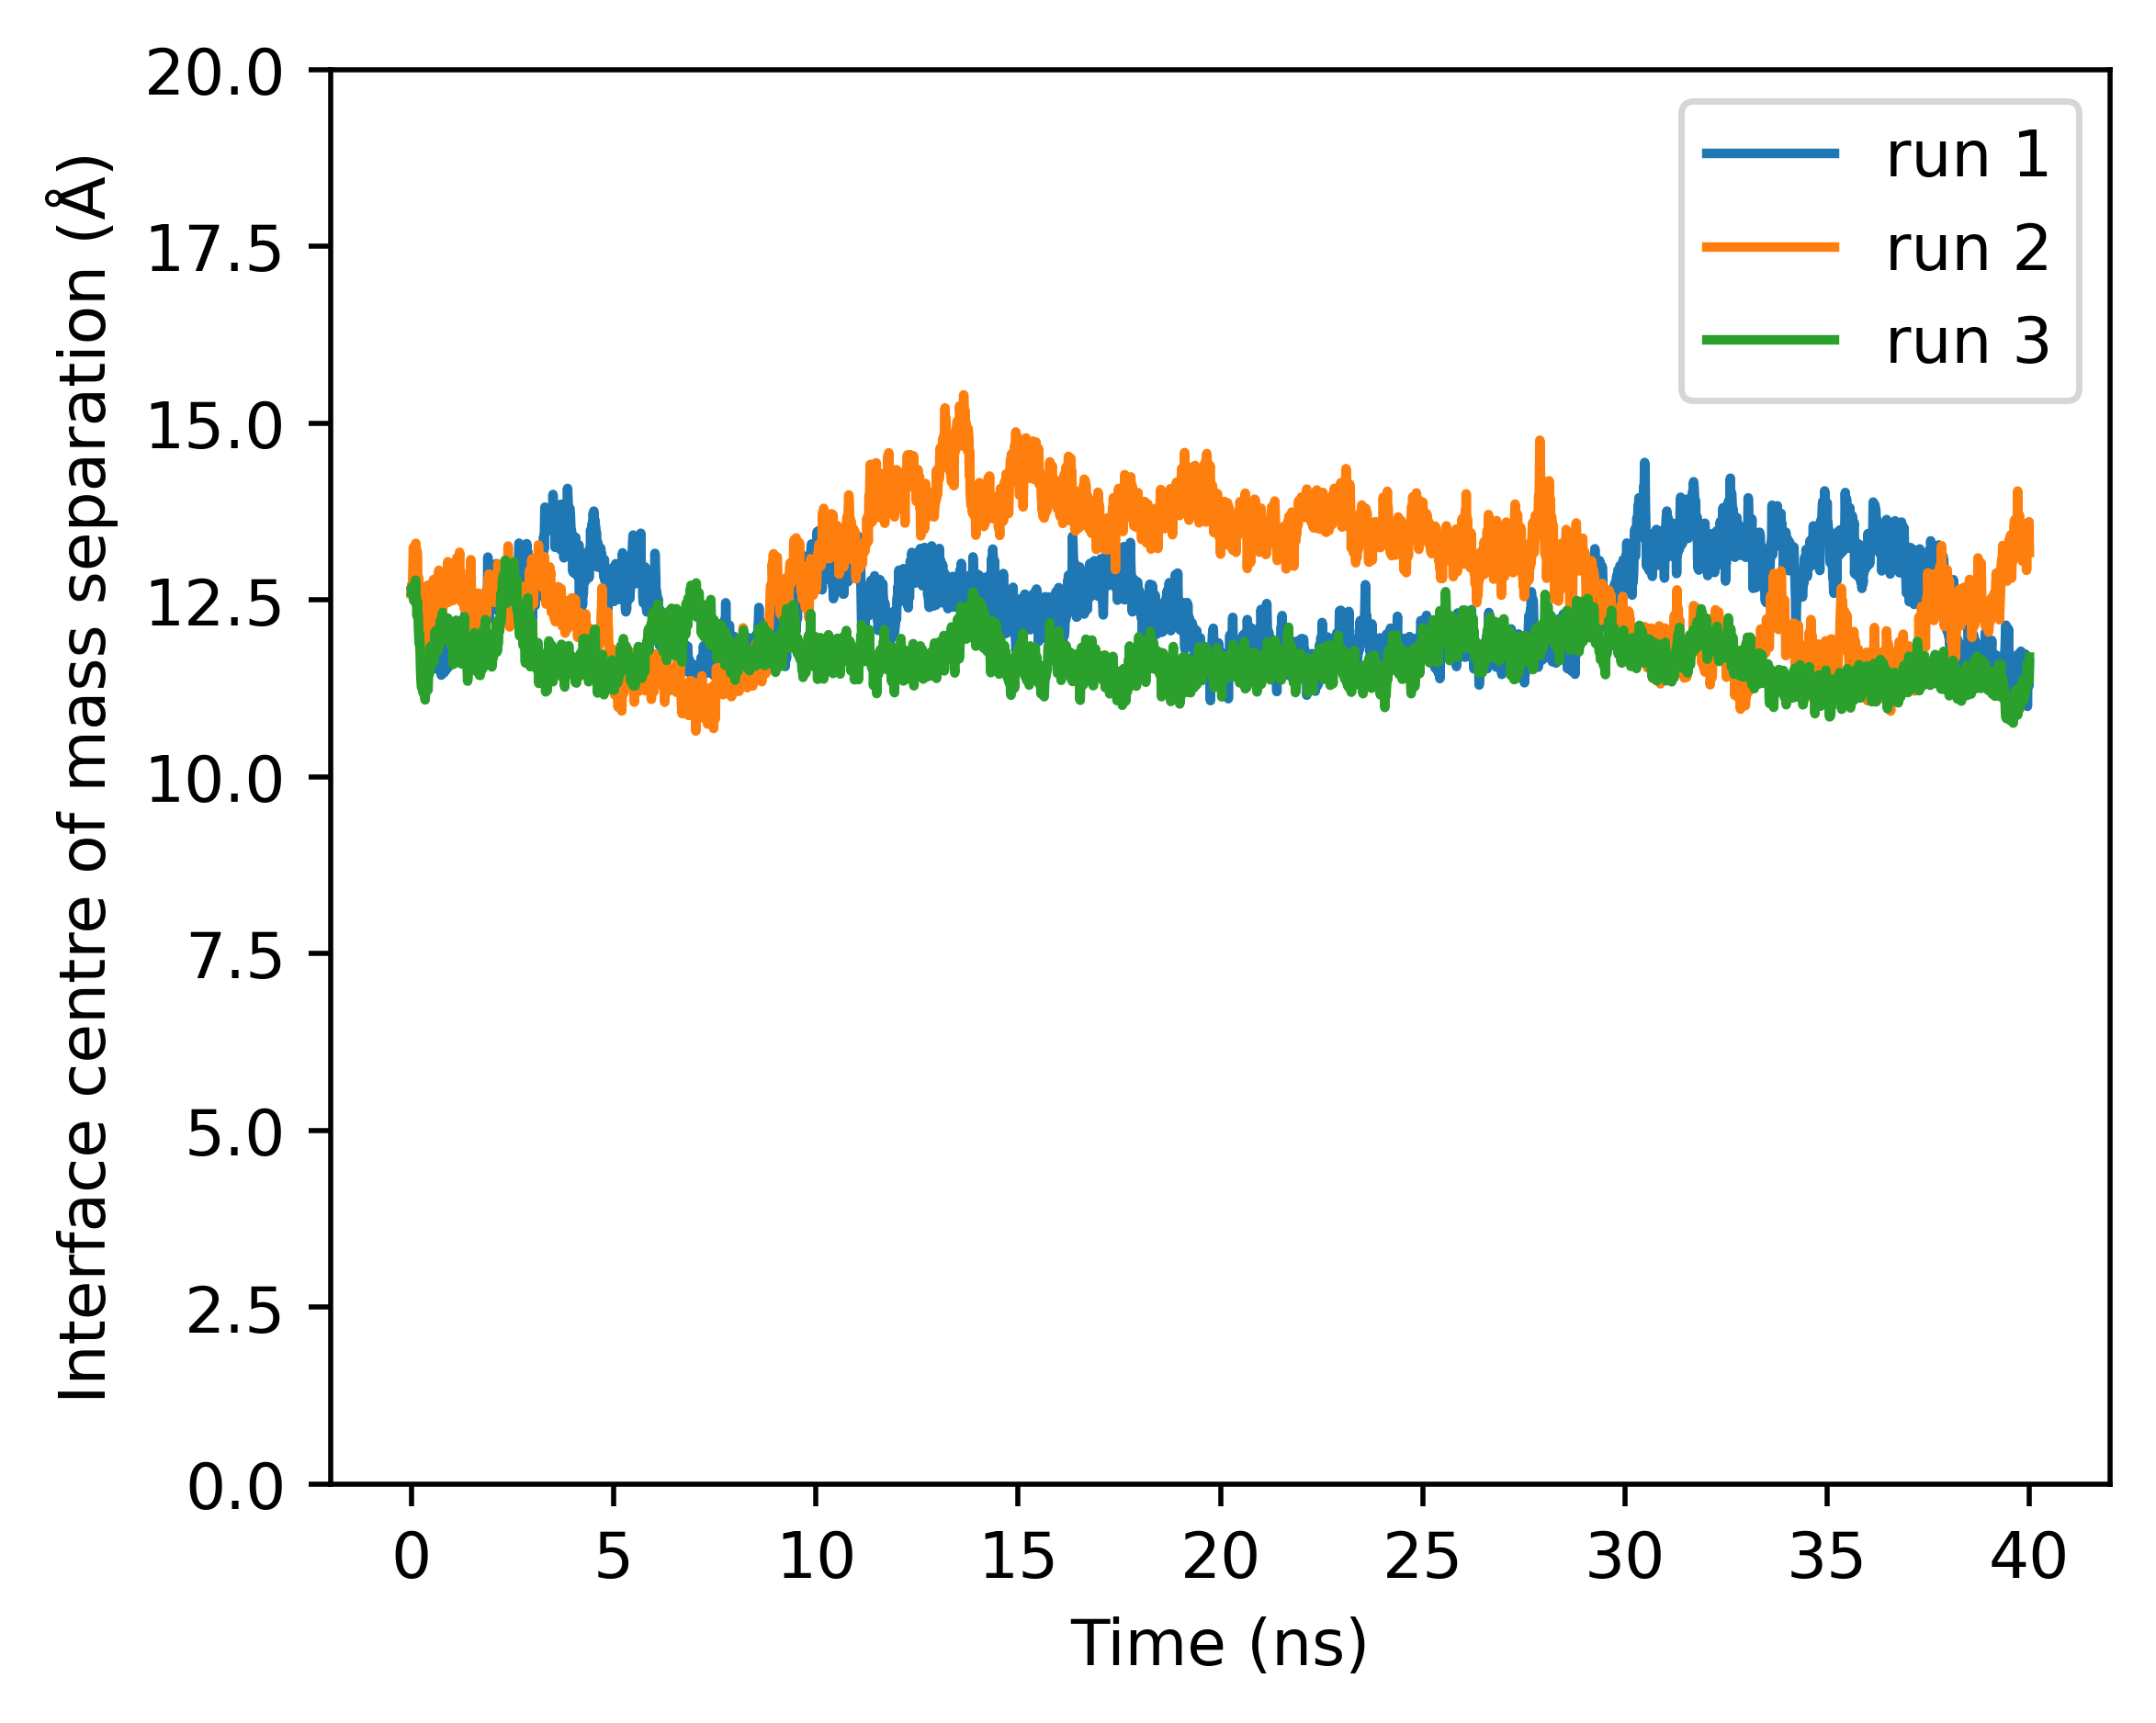

In [42]:
plt.figure(figsize=(5,4), dpi=500)

labels = {0:1, 2:2, 4:3}

for n_run in [0,2,4]:
    x = np.linspace(0,40,len(CoM_sep_data[n_run]))
    plt.plot(x, CoM_sep_data[n_run], label=f"run {labels[n_run]}")

plt.ylim(0,20)
plt.ylabel('Interface centre of mass separation (Å)')
plt.xlabel('Time (ns)')
plt.legend()
plt.show()

Printing the interface residue indices

In [46]:
u = mda.Universe('structures/complex.prmtop', f'structures/complex.inpcrd')

rec_group = [4, 18, 37, 56, 81, 96, 107, 126, 136, 160, 177, 193, 215, 226, 245, 264, 286, 307, 318, 332, 346, 400, 406, 425, 447, 453, 521, 610, 629, 649, 655, 666, 688, 694, 710, 727, 789, 941, 1872, 1899, 1905, 1920, 1941, 1960, 1999, 2026, 2057, 2068, 2084, 2095, 2102, 2112, 2123, 2133, 2140, 2164, 2183, 2197, 2219, 2463]
lig_group = [3032, 3054, 3071, 3088, 3333, 3360, 3366, 3378, 3442, 4051, 4072, 4091, 4112, 4126, 4156, 4162, 4169, 4181, 4193, 4212, 4228, 4247, 4264, 4274, 4289, 4824, 4834, 4856, 4878, 4895, 4905, 4915, 4936, 4946, 4978, 5025, 5055, 5061, 5077, 5089, 5105, 5120, 5130, 5149, 5156, 5175, 5192, 5204, 5890, 5911, 5933, 5953, 5965, 5982, 5997, 6013, 6039]

rec_atoms = u.atoms[rec_group]
lig_atoms = u.atoms[lig_group]

rec_res = [resid for resid in rec_atoms.resids]
lig_res = [resid for resid in lig_atoms.resids]
print(lig_res)

[190, 191, 192, 193, 208, 209, 210, 211, 214, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 364, 365, 366, 368, 369, 370, 371, 372, 374]


/home/benedicttan/miniconda3/envs/openbiosim/lib/python3.10/site-packages/MDAnalysis/topology/TOPParser.py:342: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)
